# Inicio

In [1]:
import os

os.environ["LOKY_MAX_CPU_COUNT"] = "8"

In [2]:
# Bibliotecas fundamentais
import numpy as np
import pandas as pd

# Bibliotecas gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold, KFold
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OrdinalEncoder,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
)

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# Classificadores
# referência
from sklearn.dummy import DummyClassifier

# lineares
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier

# árvores
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance

# SVM
from sklearn.svm import SVC

# kNN
from sklearn.neighbors import KNeighborsClassifier


# Configurações e importações gerais
from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS
from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)

sns.set_theme(palette="bright")

# Exportar o modelo
from src.config import MODELO_FINAL
from joblib import dump

In [3]:
df = pd.read_parquet(DADOS_TRATADOS)


with pd.option_context("display.max_columns", 35):
    display(df.head())

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2


In [4]:
colunas_categoricas_nao_ordenadas = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "OverTime",
]

colunas_categoricas_ordenadas = [
    "Education",
    "EnvironmentSatisfaction",
    "JobSatisfaction",
    "JobInvolvement",
    "JobLevel",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "StockOptionLevel",
    "WorkLifeBalance",
]

coluna_alvo = ["Attrition"]

colunas_numericas = [
    coluna for coluna in df.columns if coluna not in (
        colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas + coluna_alvo
    )
]

## Padronização das colunas

In [5]:
# Colunas com distribuição pouco definida merecem um tratamento de escala mais simples

cols_min_max = [
    'DailyRate',
    'HourlyRate',
    'MonthlyRate',
]

# Colunas com distribuição próximas da normal, porém com leve distorção ou assimetria
cols_std = ["Age"]

# Colunas com maiores assimetrias e distorções merecem tratamento de normalização mais agressivo 
cols_pwr_tr = [c for c in colunas_numericas
               if c not in cols_min_max + cols_std]

# Estudo Inicial dos Modelos

## Preparação inicial

In [6]:
X = df.drop(columns=coluna_alvo)
y = df[coluna_alvo]

In [7]:
le = LabelEncoder()
y = le.fit_transform(y.values.ravel())

print(y[:5], le.classes_)

[1 0 1 0 0] ['No' 'Yes']


Note que a **classe positiva** significa o `Attrition` (saída do funcionário da empresa) e a **classe negativa** a permanência

In [8]:
kf = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=RANDOM_STATE)

## Preparação dos modelos e tratamento

In [9]:
# Preprocessamento

preprocessamento_arvore = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop='first'), colunas_categoricas_nao_ordenadas),
        ("ordinal", OrdinalEncoder(categories='auto'), colunas_categoricas_ordenadas),
    ]
)

preprocessamento = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop='first'), colunas_categoricas_nao_ordenadas),
        ("ordinal", OrdinalEncoder(categories='auto'), colunas_categoricas_ordenadas),
        ("min_max", MinMaxScaler(), cols_min_max),
        ("stdscaler", StandardScaler(), cols_std),
        ("power_transform", PowerTransformer(), cols_pwr_tr),
    ]
)

In [10]:
# Classificadores

classificadores = {

    # Referência
    "DummyClassifier": {
        "preprocessor": None,
        "classificador": DummyClassifier(strategy="stratified"),
    },


    # Lineares
    "Perceptron": {
        "preprocessor": preprocessamento,
        "classificador": Perceptron(n_jobs=-1)
    },

    "LogisticRegression": {
        "preprocessor": preprocessamento,
        "classificador": LogisticRegression(class_weight="balanced") 
        # n_jobs inútil para classificação binária. 

        ## Na classificação binária, o LogisticRegression precisa treinar apenas um classificador.
        ## A otimização (solver) desse classificador é majoritariamente sequencial. 
        ## O n_jobs não consegue distribuir o cálculo de uma única função de custo por todos os núcleos.
    },

    "SGDClassifier": {
        "preprocessor": preprocessamento,
        "classificador": SGDClassifier(random_state=RANDOM_STATE,
                                       n_jobs=-1)
    },


    # Árvore de Decisão
    "DecisionTreeClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": DecisionTreeClassifier(random_state=RANDOM_STATE)
    },
    
    "ExtraTreesClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": ExtraTreesClassifier(random_state=RANDOM_STATE,
                                              n_jobs=-1)
    },                                              

    "RandomForestClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": RandomForestClassifier(random_state=RANDOM_STATE,
                                               n_jobs=-1)
    },

    "XGBClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": XGBClassifier(random_state=RANDOM_STATE,
                                        n_jobs=-1)
    },

    "LGBMClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": LGBMClassifier(random_state=RANDOM_STATE,
                                        n_jobs=-1,
                                        verbose=-1)
    },
  
    # Outros
    "SVC": {
        "preprocessor": preprocessamento,
        "classificador": SVC()
    },

    "KNeighborsClassifier": {
        "preprocessor": preprocessamento,
        "classificador": KNeighborsClassifier()
    },

}

In [11]:
# Dicionário de resultados
dict_resultados = {}

for modelo, classificador in classificadores.items():

    # criando a pipiline
    pipeline = Pipeline([
        ('preprocessor', classificador['preprocessor']),
        ("sampler", RandomUnderSampler(random_state=RANDOM_STATE)),
        (modelo, classificador['classificador'])
    ])

    # cross validate

    scores = cross_validate(
        estimator=pipeline, 
        X=X, y=y,
        cv=kf,
        scoring=[
            "accuracy",
            "balanced_accuracy",
            "f1",
            "precision",
            "recall",
            "roc_auc",
            "average_precision",
        ],
    )

    dict_resultados[modelo] = scores

dict_resultados['KNeighborsClassifier']

{'fit_time': array([0.0216763 , 0.0142405 , 0.02743959, 0.02314329, 0.03925633]),
 'score_time': array([0.10229015, 0.02938914, 0.03505802, 0.03001785, 0.0271337 ]),
 'test_accuracy': array([0.72789116, 0.70068027, 0.75510204, 0.76870748, 0.70068027]),
 'test_balanced_accuracy': array([0.68648374, 0.62830285, 0.7078129 , 0.65561203, 0.64958222]),
 'test_f1': array([0.42857143, 0.36231884, 0.45454545, 0.40350877, 0.38028169]),
 'test_precision': array([0.32608696, 0.27777778, 0.35294118, 0.34328358, 0.28421053]),
 'test_recall': array([0.625     , 0.52083333, 0.63829787, 0.4893617 , 0.57446809]),
 'test_roc_auc': array([0.72044377, 0.71870766, 0.79903523, 0.72870187, 0.67408907]),
 'test_average_precision': array([0.36421199, 0.31514742, 0.47232002, 0.31325684, 0.31309821])}

## Avaliação da métricas dos modelos testados

In [12]:
## Cria o df
df_resultados = pd.DataFrame(dict_resultados).T.reset_index().rename(columns={'index' : 'model'})

## expande os valores para linhas (antes, cada regirstro tinha todas as métricas em uma só linha)
df_resultados = df_resultados.explode(column=df_resultados.columns[1:].to_list()).reset_index(drop=True)

## marcador de tempo
df_resultados["time_seconds"] = df_resultados["fit_time"] + df_resultados["score_time"]

## transforma as métricas em numérico
for c in df_resultados.columns[1:]:

    df_resultados[c] = pd.to_numeric(df_resultados[c], errors='coerce')

df_resultados.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   model                   55 non-null     object 
 1   fit_time                55 non-null     float64
 2   score_time              55 non-null     float64
 3   test_accuracy           55 non-null     float64
 4   test_balanced_accuracy  55 non-null     float64
 5   test_f1                 55 non-null     float64
 6   test_precision          55 non-null     float64
 7   test_recall             55 non-null     float64
 8   test_roc_auc            55 non-null     float64
 9   test_average_precision  55 non-null     float64
 10  time_seconds            55 non-null     float64
dtypes: float64(10), object(1)
memory usage: 4.9+ KB


Considerando o cenário de desbalanceamento original, poderia ser injusto trocar a métrica agora de referência agora. Entretanto, faremos uma avaliação mais holística para manter certo compromisso entre _recall_ e _precision_, sem negligênciar aspectos importântes, como consistência e outras métricas.

In [13]:
df_resultados.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.005347,0.007659,0.508844,0.509596,0.251095,0.166597,0.510638,0.478259,0.158052,0.013005
DecisionTreeClassifier,0.006836,0.025361,0.676190,0.662293,0.388626,0.279254,0.641667,0.662293,0.238438,0.032196
KNeighborsClassifier,0.025151,0.044778,0.730612,0.665559,0.405845,0.316860,0.569592,0.728196,0.355607,0.069929
ExtraTreesClassifier,0.095623,0.066668,0.715646,0.694146,0.429419,0.318246,0.662411,0.755737,0.417020,0.162291
XGBClassifier,0.112430,0.019160,0.714286,0.700185,0.434119,0.319391,0.679344,0.773475,0.444256,0.131590
Perceptron,0.027950,0.030098,0.626531,0.663889,0.394674,0.281765,0.718440,0.758989,0.457355,0.058049
RandomForestClassifier,0.125944,0.067081,0.717007,0.710156,0.444007,0.325501,0.700089,0.786617,0.473739,0.193026
SGDClassifier,0.033735,0.016818,0.646939,0.683341,0.405310,0.301058,0.737500,0.772986,0.478695,0.050553
LGBMClassifier,0.024314,0.015517,0.723810,0.715876,0.451201,0.332240,0.704255,0.790840,0.482381,0.039831


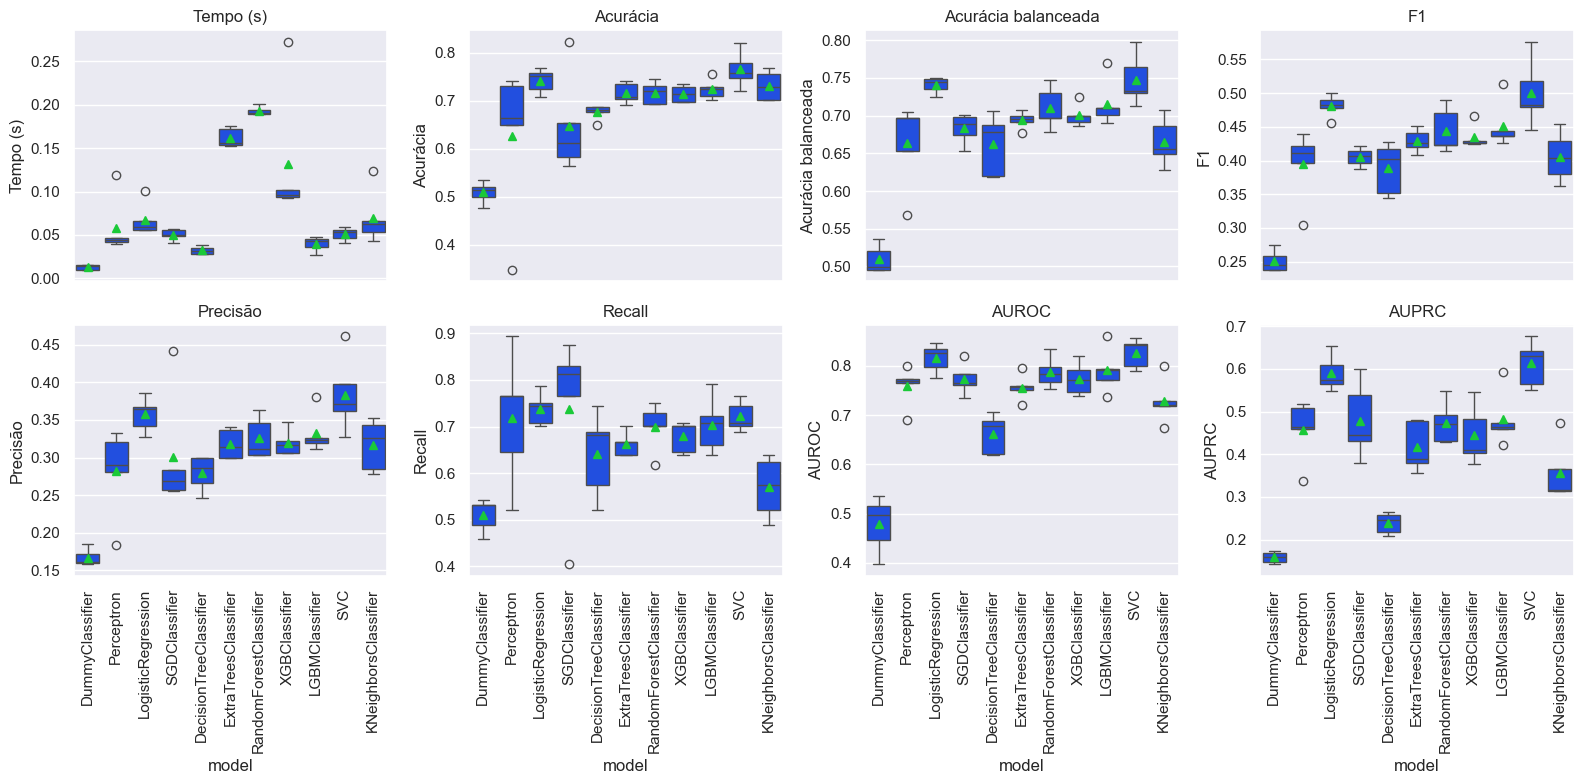

In [14]:
# boxplots

fig, axs = plt.subplots(2, 4, 
                        figsize=(16, 8), 
                         sharex=True)

comparar_metricas = [
        "time_seconds",
        "test_accuracy",
        "test_balanced_accuracy",
        "test_f1",
        "test_precision",
        "test_recall",
        "test_roc_auc",
        "test_average_precision",
    ]

nomes_metricas = [
        "Tempo (s)",
        "Acurácia",
        "Acurácia balanceada",
        "F1",
        "Precisão",
        "Recall",
        "AUROC",
        "AUPRC",
    ]


for ax, metrica, nome in zip(axs.flatten(), comparar_metricas, nomes_metricas):

    sns.boxplot(

        data=df_resultados,
        x='model',
        y=metrica,
        ax=ax,
        showmeans=True

    )

    ax.set_title(nome)
    ax.set_ylabel(nome)
    ax.tick_params(axis='x', rotation=90)


plt.tight_layout()
plt.show()

- Caso de escolha de um único Modelo

1. LogisticRegression e SVC foram, detre todos, os melhores na métrica de referência (AUPRC)
2. LogisticRegression e SVC foram, detre todos, os melhores ao acertar a classe positiva (Recall) e com menor variação de resultados. LogisticRegression levemente melhor.
3. Ambos com tempos equivalentes e demais métricas, como Precisão e F1 equivalentes;
4. LogisticRegression é mais simples de explicar;


- Caso de escolha de mais de um Modelo

1. LogisticRegression e SVC foram, detre todos, os melhores na métrica de referência (AUPRC)
2. LogisticRegression e SVC foram, detre todos, os melhores ao acertar a classe positiva (Recall) e com menor variação de resultados. LogisticRegression levemente melhor.
3. Modelos rápidos de treinar.
4. Modelos relativamente simples.
5. Vantagem de avaliar o _tuning_ para dois modelos diferentes e entender melhor a natureza da base.



# Estudo do modelo mais promissor

Vamos escolher o solver saga, pois ele é generalista e nos permitirá acessar mais combinações de hiperparâmetros.

In [15]:
# param grid para o modelo em estudo

param_grid = [

# Parâmetros gerais
{    
    "classificador__C" : [0.1, 1, 10, 100],
    "classificador__penalty" : ["l1", "l2", None],
},

# Parâmetros elasticnet
{    
    "classificador__C" : [0.1, 1, 10, 100],
    "classificador__penalty" : ["elasticnet"],
    'classificador__l1_ratio' : [0.1, 0.25, 0.5, 0.75, 0.9]
}

]

clf = LogisticRegression(solver='saga',
                         random_state=RANDOM_STATE)

In [16]:
refit_metric = 'average_precision'

# Criando a pipiline
pipeline = Pipeline([
    ('preprocessor', preprocessamento),
    ("sampler", RandomUnderSampler(random_state=RANDOM_STATE)),
    ('classificador', clf)
])

# Criando o GridSearch
grid_search = GridSearchCV(
    estimator=pipeline,
    cv=kf,
    param_grid=param_grid,
    scoring=[
        "accuracy",
        "balanced_accuracy",
        "f1",
        "precision",
        "recall",
        "roc_auc",
        "average_precision",
    ],
    refit=refit_metric,
    n_jobs=-1,
    return_train_score=False,
    verbose=1,
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
             param_grid=[{'classificador__C': [0.1, 1, 10, 100],
                          'classificador__penalty': ['l1', 'l2', None]},
                         {'classificador__C': [0.1, 1, 10, 100],
                          'classificador__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9],
                          'classificador__penalty': ['elasticnet']}],
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [17]:
grid_search.fit(X, y)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


c:\Users\danie\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
             param_grid=[{'classificador__C': [0.1, 1, 10, 100],
                          'classificador__penalty': ['l1', 'l2', None]},
                         {'classificador__C': [0.1, 1, 10, 100],
                          'classificador__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9],
                          'classificador__penalty': ['elasticnet']}],
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

## Análise e discussão do Modelo mais promissor

In [18]:
grid_search.best_params_

{'classificador__C': 0.1,
 'classificador__l1_ratio': 0.1,
 'classificador__penalty': 'elasticnet'}

In [19]:
grid_search.best_score_

np.float64(0.6174426856945511)

Modelo um pouco diferente, porém ainda Elasticnet e com score idêntico ao sem balanceamento da base de dados, logo, ajustar o número de interações máximas `max_iter` pode ser _overengeneering_.

In [20]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'OverTime']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['Education',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'JobInvolvement', 'JobLevel',
                                                   'PerformanceRating',
                                                   'RelationshipSatis...
                                                   'MonthlyIncome',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('classificador',
                 LogisticRegression(C=0.1, l1_ratio=0.1, penalty='elasticnet',
                                    random_state=42, solver='saga'))])

Como verificar os demais parâmetros do melhor modelo?

In [21]:
# grid_search.best_estimator_["preprocessor"].get_feature_names_out()

In [22]:
# grid_search.cv_results_.keys()

In [23]:
# grid_search.cv_results_['mean_test_average_precision']

In [24]:
grid_search.cv_results_['mean_test_average_precision'][grid_search.best_index_]

np.float64(0.6174426856945511)

In [25]:
colunas_test = [c for c in df_resultados.columns
                if c.startswith('test')]

colunas_test_mean = ['mean_' + c for c in colunas_test]

colunas_test_mean

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_average_precision']

In [26]:
for c in colunas_test_mean:
    print(f'coluna {c}: {round(grid_search.cv_results_[c][grid_search.best_index_], 2)}')


coluna mean_test_accuracy: 0.75
coluna mean_test_balanced_accuracy: 0.74
coluna mean_test_f1: 0.48
coluna mean_test_precision: 0.36
coluna mean_test_recall: 0.74
coluna mean_test_roc_auc: 0.82
coluna mean_test_average_precision: 0.62


In [27]:
# grid_search.best_estimator_['classificador'].coef_

Como é um modelo linear de regressão, é prudente avalidar as principais _features_

In [28]:
coefs = pd.DataFrame(
    data=grid_search.best_estimator_['classificador'].coef_[0],
    index=grid_search.best_estimator_['preprocessor'].get_feature_names_out(),
    columns=['Coeficientes']
).sort_values(by='Coeficientes', ascending=False)

coefs.head()

,Coeficientes
one_hot__OverTime_Yes,0.982897
one_hot__MaritalStatus_Single,0.459216
one_hot__BusinessTravel_Travel_Frequently,0.447673
power_transform__NumCompaniesWorked,0.337072
one_hot__JobRole_Laboratory Technician,0.311731


In [29]:
coefs[coefs.values == 0]

,Coeficientes
stdscaler__Age,0.0
one_hot__BusinessTravel_Travel_Rarely,0.0
one_hot__EducationField_Medical,0.0
one_hot__EducationField_Other,0.0
one_hot__JobRole_Human Resources,0.0
one_hot__MaritalStatus_Married,0.0
ordinal__PerformanceRating,0.0
min_max__HourlyRate,0.0
min_max__MonthlyRate,0.0


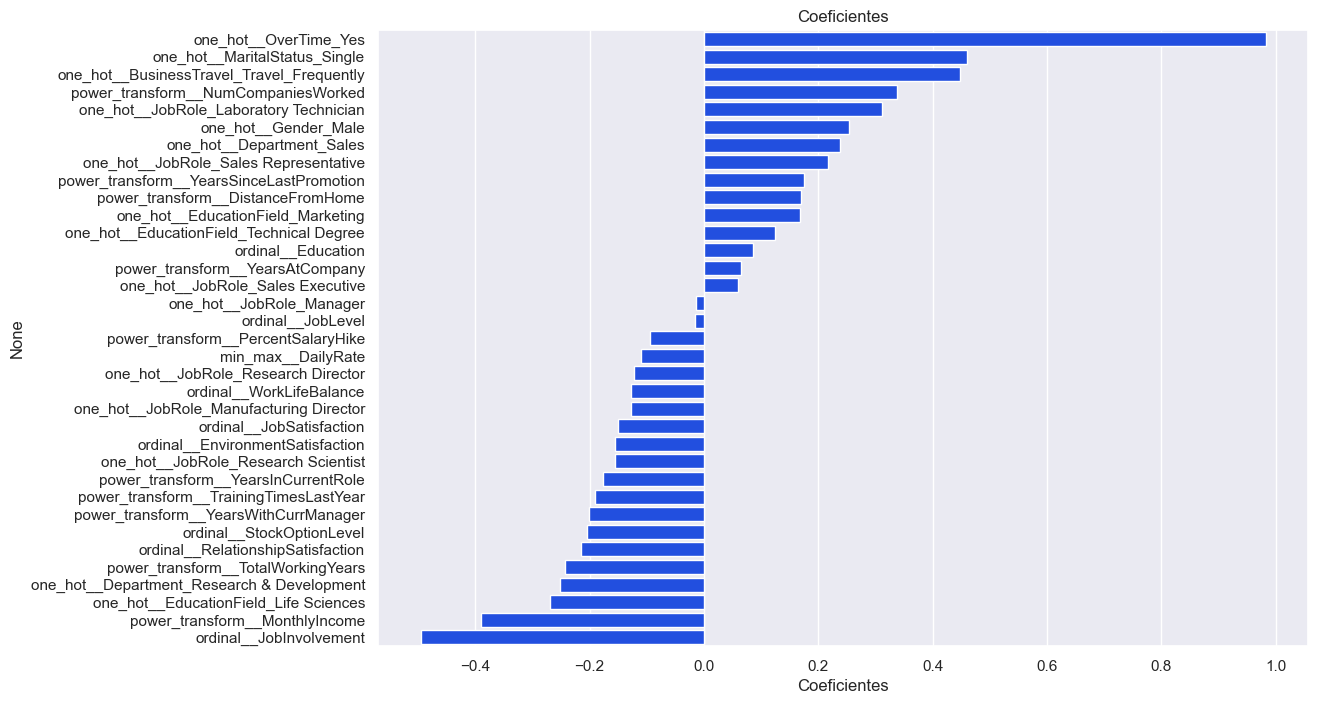

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(
    data=coefs[coefs.values != 0],
    x='Coeficientes',
    y=coefs[coefs.values != 0].index,
    ax=ax
)


plt.title("Coeficientes")
plt.show()

Os coeficientes $w_i$ em uma regressão logística não são interpretados diretamente como em uma regressão linear. Em vez disso, eles representam o **logaritmo do odds ratio** associado a cada variável.

- **Odds (Chances):** Razão entre a probabilidade do evento ocorrer e a probabilidade de não ocorrer.

  $$
  \text{Odds} = \frac{\text{Probabilidade do Evento}}{1 - \text{Probabilidade do Evento}}
  $$

- **Odds Ratio:** Medida de quanto as chances mudam com uma unidade de aumento na variável independente.

- **Coeficiente ($w_i$):** Representa a mudança nos **log-odds** do resultado por unidade de aumento na variável $X_i$.

  $$
  \text{Log-Odds} = w_0 + w_1X_1 + w_2X_2 + \dots + w_nX_n
  $$

Para interpretar os coeficientes em termos mais intuitivos, podemos calcular o **exponencial do coeficiente**:

$$
\text{Odds Ratio} = e^{w_i}
$$

- **Interpretação do Odds Ratio:**
  - **Valor > 1:** Aumenta as chances do evento ocorrer.
  - **Valor = 1:** Não afeta as chances.
  - **Valor < 1:** Diminui as chances do evento ocorrer.


Imagine que estamos modelando a probabilidade de um paciente ter uma doença com base na idade e no hábito de fumar.

$$
\text{Log-Odds} = w_0 + w_1 (\text{Idade}) + w_2 (\text{Fumante})
$$

Suponha que obtivemos os seguintes coeficientes:

- $w_0 = -2$
- $w_1 = 0{,}05$
- $w_2 = 1{,}5$

1. **Coeficiente da Idade ($w_1 = 0{,}05$):**

   - **Log-Odds:** Para cada aumento de 1 ano na idade, o log-odds de ter a doença aumenta em 0,05.
   - **Odds Ratio:** $e^{0{,}05} \approx 1{,}051$
   - **Interpretação:** Cada ano adicional de idade aumenta as chances de ter a doença em aproximadamente **5,1%**.

2. **Coeficiente do Fumante ($w_2 = 1{,}5$):**

   - **Log-Odds:** Se o paciente é fumante (1), o log-odds de ter a doença aumenta em 1,5 em comparação com não fumantes (0).
   - **Odds Ratio:** $e^{1{,}5} \approx 4{,}48$
   - **Interpretação:** Fumantes têm **4,48 vezes** mais chances de ter a doença do que não fumantes.


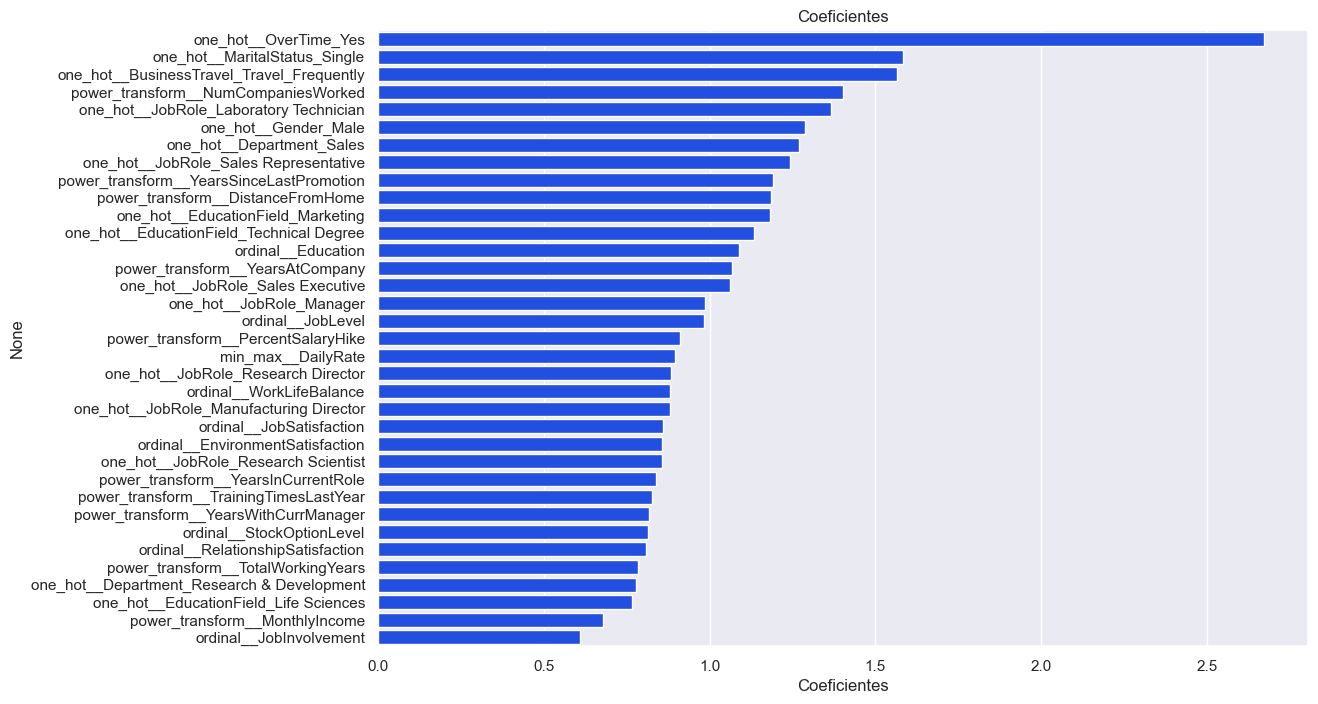

In [31]:
df_exp = coefs.copy()
df_exp['Coeficientes'] = np.exp(df_exp['Coeficientes'])

fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(
    data=df_exp[df_exp.values !=1],
    x='Coeficientes',
    y=df_exp[df_exp.values !=1].index,
    ax=ax
)


plt.title("Coeficientes")
plt.show()

_Features_ que suportam uma tendencia de sair na empresa

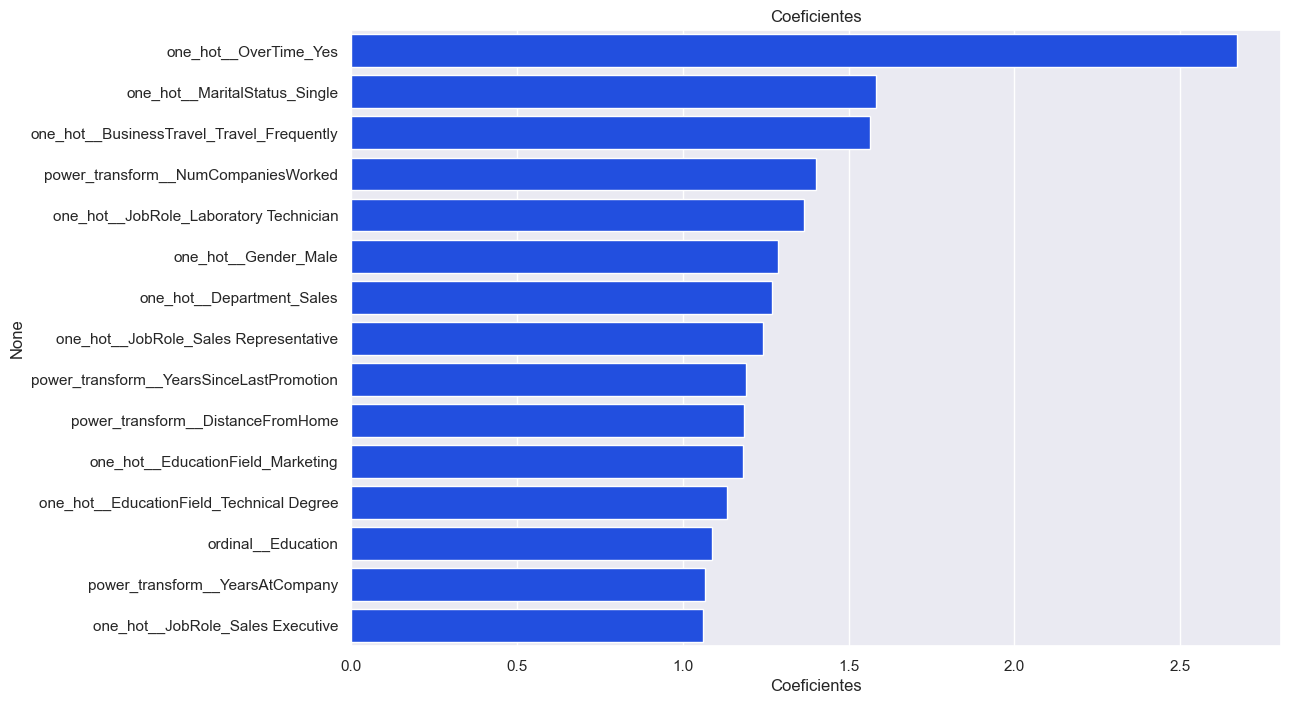

In [32]:
df_exp = coefs.copy()
df_exp['Coeficientes'] = np.exp(df_exp['Coeficientes'])

fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(
    data=df_exp[df_exp.values > 1],
    x='Coeficientes',
    y=df_exp[df_exp.values > 1].index,
    ax=ax
)


plt.title("Coeficientes")
plt.show()

_Features_ que suportam uma tendencia de se manter na empresa

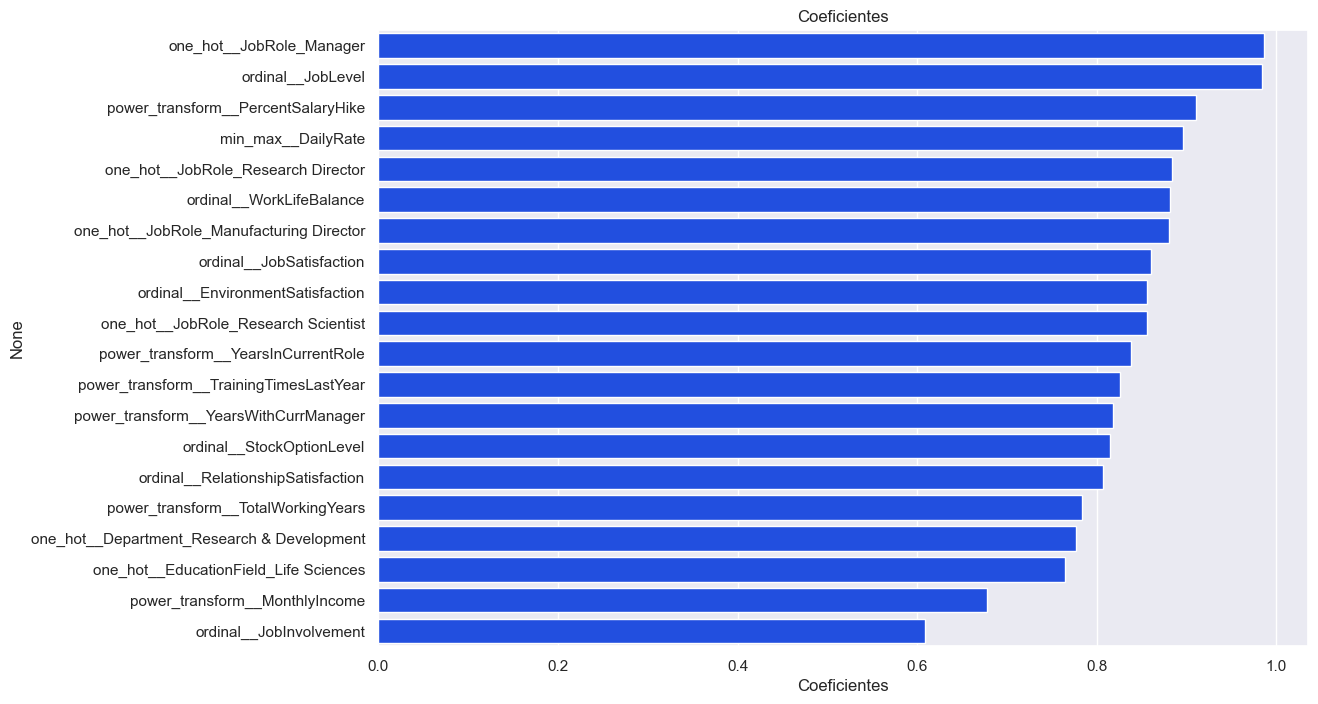

In [33]:
df_exp = coefs.copy()
df_exp['Coeficientes'] = np.exp(df_exp['Coeficientes'])

fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(
    data=df_exp[df_exp.values <1],
    x='Coeficientes',
    y=df_exp[df_exp.values <1].index,
    ax=ax
)


plt.title("Coeficientes")
plt.show()

Tomando apenas as mais relevantes, veja:

In [ ]:
coefs_2 = coefs[(coefs.values >=0.3) | (coefs.values <= -0.25)]

mapeamento = {
    'one_hot__OverTime_Yes': 'Faz Horas Extras',
    'one_hot__MaritalStatus_Single': 'Estado Civil: Solteiro',
    'one_hot__BusinessTravel_Travel_Frequently': 'Viaja Frequentemente',
    'power_transform__NumCompaniesWorked': 'Total de Empresas que já trabalhou',
    'one_hot__JobRole_Laboratory Technician': 'Cargo: Técnico de Laboratório',
    'one_hot__Department_Research & Development': 'Departamento: P&D',
    'one_hot__EducationField_Life Sciences': 'Formação: Ciências da Vida',
    'power_transform__MonthlyIncome': 'Salário Mensal',
    'ordinal__JobInvolvement': 'Nível de Envolvimento no Trabalho'
}

coefs_2.index = coefs_2.index.map(lambda x: mapeamento.get(x, x))
coefs_2

,Coeficientes
Faz Horas Extras,0.982897
Estado Civil: Solteiro,0.459216
Viaja Frequentemente,0.447673
Total de Empresas que já trabalhou,0.337072
Cargo: Técnico de Laboratório,0.311731
Departamento: P&D,-0.252369
Formação: Ciências da Vida,-0.268742
Salário Mensal,-0.389700
Nível de Envolvimento no Trabalho,-0.495667


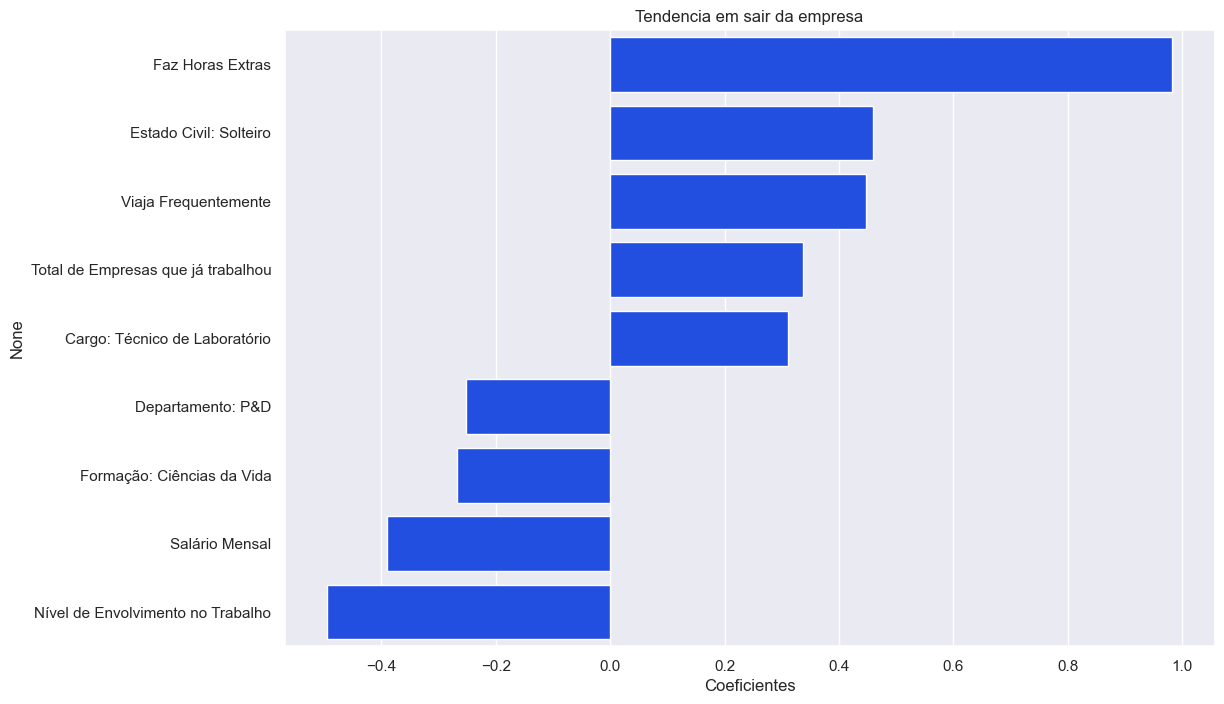

In [65]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(
    data=coefs_2,
    x='Coeficientes',
    y=coefs_2.index,
    ax=ax
)


plt.title("Tendencia em sair da empresa")
plt.show()

Proporção de acertos e erros do modelo:

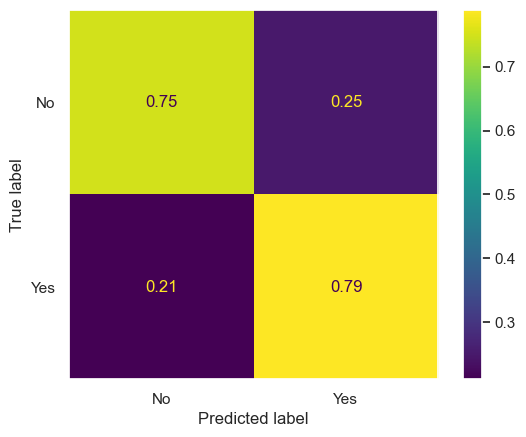

In [34]:
ConfusionMatrixDisplay.from_estimator(
    estimator=grid_search.best_estimator_,
    X=X,y=y,
    display_labels=le.classes_,    
    normalize="true"
)

plt.grid(False)
plt.show()

-  **Plano de ação**

1. Avaliar os motivos que levam os funcionários a fazerem hora extra, visto ser a principal caracte´ristica para `attrition`

    - Mão de obra insuficiente: setores engargalados;
    - Falta de organização institucional: processos difusos e complexos;
    - Falta de treinamento: colaboradores levam mais tempo do que deveriam nas tarefas;
    - Necessidade de investimento em tecnologia: automações e simplificações na comunicação

- Possibilidade de diminuir as viagens de negócios.
  - Como isso afeta a equipe de vendas?
  - será que todas as visitas presenciais são necessárias? Existem alternativas à distância?

- Como a renda mensal de cada setor e nível da empresa se compara com o mercado?  
    - Uma vez que esse é um fator de retenção, será que é o momento de revisitar os salários para equalizar valores de mercado?


- Conclusão:

Temos um modelo simples de explicar para o público leigo, robusto o sugificente para uma base simples e com métricas de tempo e _score_ bem promissoras com um tratamento simples da base. Iremos exportar para produção, porém, de antemão, já é possível avaliar características da base e ter _insights_ norteadores de decisões para a empresa. Logo, antes de tudo, esse é um modelo que ainda permite mais otimizações, caso o objetivo seja previsão, e com uma análise simples como a descrita acima já permitiu um ganho de conhecimento sobre a empresa e perfil geral. 

Esse pode ser o primeiro trabalho de outros mais sofisticados e específicos que podem gerar um retorno e impacto significativo na decisões e mundaças previstas para a empresa.

# Exportação para produção

In [35]:
dump(grid_search.best_estimator_, MODELO_FINAL)

['C:\\Users\\danie\\Desktop\\Daniel\\Estudo\\Cursos\\Ciência de Dados Impressionadora\\22 Projeto - IBM attrition\\modelos\\logistic_regression_rus.joblib']

Ainda em tempo, como o modelo escolhido é possível associar uma probalidade ao evento `Attrition`, veja o exemplo:

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

grid_search.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'OverTime']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['Education',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'JobInvolvement', 'JobLevel',
                                                   'PerformanceRating',
                                                   'RelationshipSatis...
                                                   'MonthlyIncome',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('classificador',
                 LogisticRegression(C=0.1, l1_ratio=0.1, penalty='elasticnet',
                                    random_state=42, solver='saga'))])

escolhi esse momento, após exportação do modelo, pois o re-treino poderá impactar no modelo e o objetivo é apenas deixar claro ao leitor que faremos uma escolha convervadora ao indicar a probabilidade ao invés de apenas catagorizar cada entrada fornecida!

In [37]:
y_pred_prob = grid_search.best_estimator_.predict_proba(X_test)

y_pred_prob[:5]

array([[0.66152941, 0.33847059],
       [0.81136262, 0.18863738],
       [0.31311325, 0.68688675],
       [0.82441598, 0.17558402],
       [0.78411687, 0.21588313]])

In [38]:
# chance de ser da classe 1

y_pred_prob[:5, 1:]

array([[0.33847059],
       [0.18863738],
       [0.68688675],
       [0.17558402],
       [0.21588313]])

Dessa forma, é posível avaliar de forma mais estratégica as características do funcionário e sua tendência a sair.

Isso permite uma tratativa mais direcionada, ao invés de indiscriminada, o que poderia consumir mais tempo e recursos do plano de ação proposto acima.